# Analysis of real data comparing MEGAN and Kraken
previous test were made with artificial data and now it is time to use some real data.
1. Introduction
    which data is used and what are the settings
2. Prepare the data for analysis and create a data-structure to store the information
3. visualize the data for presentation

In [1]:
import os
from pathlib import *
import pandas as pd
import pysam
import matplotlib.pyplot as plt

In [25]:
"""
Try to get the data from the file. If not there, count again
"""
try:
    data = pd.read_csv("Count_data.csv", index_col=0)

except FileNotFoundError:
    """Now count the stuff"""
    import shutil
    width = shutil.get_terminal_size()[0]
    
    exclude = ['work','analyzed','aligned','split','pseudouniq','filter_deam3or5'] #dont walk through the conda-jungle
    data = pd.DataFrame(index = ['Family','Origin','Before_BWA','After_BWA'])

    for root,dirs,files in os.walk('.'):
        dirs[:]=[d for d in dirs if d not in exclude]
        p = Path(root)
        #find all {family} folders
        if(len([x for x in p.glob("*.bam")])>0 and len(p.parts)>1):
            family = p.parts[-1]
            origin = p.parts[1]
            before_bwa = []
            after_bwa = []
            #count assigned reads before BWA
            for bam in p.glob("*.bam"):
                print(f"Opening: {bam}".ljust(width," "), end="\r")
                samfile = pysam.AlignmentFile(f"{bam}", "rb", check_sq=False)
                before_bwa.extend([x.query_name for x in samfile])

            #Count the aligned reads after BWA
            if('aligned' in os.listdir(p)):
                p = p/"aligned"
                for bam in p.glob("*bam"):
                    print(f"Opening: {bam}".ljust(width," "), end="\r")
                    samfile = pysam.AlignmentFile(f"{bam}", "rb", check_sq=False)
                    after_bwa.extend([x.query_name for x in samfile])

            #Add the data to the dataframe
            data[len(data.columns)]=[family,origin,len(set(before_bwa)),len(set(after_bwa))]
    data.to_csv("Count_data.csv")

## What Data ##

Here I have the summary of some kraken/Megan runs. The different settings are as follows:

|Name of Run | Pipeline | Deduplication? | Discard Unmapped? | 
| --- | --- | --- | --- |
|MEGAN | Snakemake | y | n |
|MEGAN_v2 | Snakemake | y | y | 
|MEGAN_v3 | Snakemake | y | n |
|Kraken | Nextflow | n | n |
|Kraken_deduped | Nextflow | y | n |
|181011_B...Allmam| Snakemake | y | y |
 
MEGAN and MEGAN_v3 where dropped because of missing "aligned" information. Maybe the BWA didnt work? 

In [27]:
#data = data.T.astype({"Before_BWA":"int64", "After_BWA":"int64"})
data = data[data.Origin != "MEGAN"]
data["Sum"] = data["Origin"].map(lambda x: data[data["Origin"]==x]["After_BWA"].sum())
data["Percentage"] = data["After_BWA"]/data["Sum"]

In [137]:
data[(data["Percentage"]>0.01) & (data["Origin"] != "MEGAN_v3")].sort_values(["Origin","Percentage"]).drop("Sum", axis=1).set_index(["Origin","Family"])#.to_csv("Sorted_by_percentage_01.csv")

Before_BWA  After_BWA  Percentage
Origin                    Family                                           
181011_B18926_MTcapAllmam Ursidae               2529       2521    0.011416
                          Hominidae             3699       3679    0.016660
                          Elephantidae          3787       3770    0.017072
                          Rhinocerotidae        4228       4227    0.019142
                          Cervidae              9244       9176    0.041554
                          Equidae              13340      13328    0.060356
                          Canidae              15371      15366    0.069585
                          Bovidae              77856      77823    0.352423
                          Hyaenidae            89067      89059    0.403305
Kraken                    Hominidae            76877      74369    0.016490
                          Elephantidae        108468     104632    0.023200
                          Rhinocerotidae      111193     108221    0.023996
                          Cervidae            182754     176319    0.039095
                          Canidae             242164     236922    0.052532
                          Equidae             283969     277050    0.061430
                          Bovidae            1394712    1367856    0.303292
                          Hyaenidae          1915142    1880849    0.417037
Kraken_dedup              Rhinocerotidae       31250       3704    0.012335
                          Hominidae            17045       6219    0.020710
                          Canidae              64508       8193    0.027284
                          Elephantidae         32546       9830    0.032735
                          Cervidae             55151      13992    0.046595
                          Equidae              66239      15926    0.053035
                          Hyaenidae           532364      75816    0.252475
                          Bovidae             372455     153274    0.510418
MEGAN_v2                  Ursidae               2411       2403    0.010893
                          Hominidae             3699       3679    0.016678
                          Elephantidae          3786       3770    0.017090
                          Rhinocerotidae        4228       4227    0.019162
                          Cervidae              9244       9176    0.041597
                          Equidae              13341      13329    0.060424
                          Canidae              15238      15233    0.069055
                          Bovidae              77874      77841    0.352875
                          Hyaenidae            89069      89061    0.403738

In [135]:
#make a dict with colors to have the same color for each family
import random
color_dict = {k:tuple(random.random() for _ in range(3)) for k in set(data.loc[data.Percentage > 0.01,"Family"])}
color_dict

{'Hyaenidae': (0.9367651373553075, 0.360247096852076, 0.6213052216998117),
 'Cervidae': (0.053731387479385995, 0.09038482119059266, 0.8386512055002672),
 'Canidae': (0.48980785980492303, 0.9361554656485086, 0.25493629581794053),
 'Elephantidae': (0.4729040490514491, 0.091197297596878, 0.6860714623593192),
 'Hominidae': (0.8733204415802478, 0.7535106672098963, 0.10665872129748111),
 'Bovidae': (0.5234256478042724, 0.2884580396616695, 0.4671799677123779),
 'Rhinocerotidae': (0.5745399658513822, 0.8253599583666542, 0.689329992765646),
 'Ursidae': (0.6251493985291812, 0.5470038325068697, 0.00752719887595199),
 'Equidae': (0.7630694716772995, 0.7782091007368589, 0.035426347189298824)}

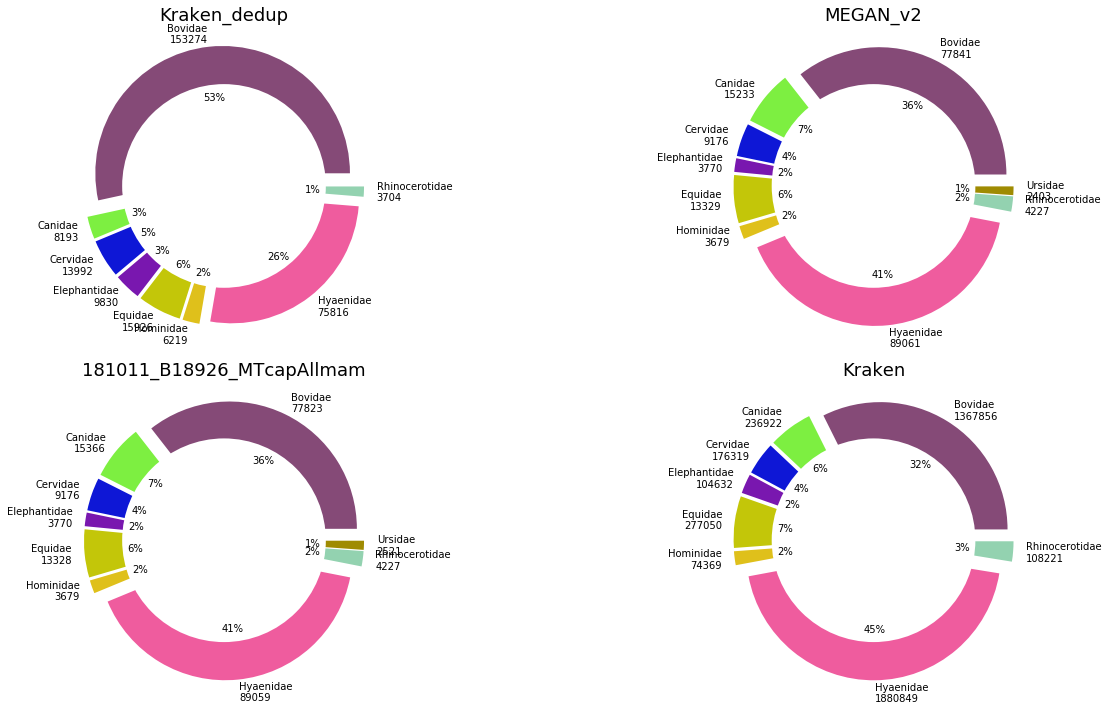

In [180]:
#print pie-chart with the families
fam_data = data[(data["Percentage"]>0.01) & (data["Origin"] != "MEGAN_v3") & (data["Origin"] != "MEGAN")]

plt.figure(figsize=(20,10))

a1 = plt.subplot2grid((2,2),(0,0),rowspan=1, colspan=1)
a2 = plt.subplot2grid((2,2),(0,1),rowspan=1, colspan=1)
a3 = plt.subplot2grid((2,2),(1,0),rowspan=1, colspan=1)
a4 = plt.subplot2grid((2,2),(1,1),rowspan=1, colspan=1)
subplot_dict = {0:a1, 1:a2, 2:a3, 3:a4}

counter = 0
for origin in set(fam_data["Origin"]):
    ax = subplot_dict[counter]
    sub_data = fam_data.loc[fam_data.Origin == origin, :].sort_values("Family")
    sub_data["Label"] = sub_data["Family"].str.cat(sub_data["After_BWA"].astype(str), sep="\n")
    
    ax.pie(sub_data["After_BWA"],labels=sub_data["Label"],autopct="%1.f%%", explode=[0.1 for _ in range(len(sub_data))] ,colors=[color_dict[x] for x in sub_data["Family"]])
    ax.set_title(origin, fontdict={"fontsize":18})
    ax.add_artist(plt.Circle((0,0),0.8, fc="white"))
    
    counter += 1

plt.tight_layout()
plt.savefig("nice_piechart.png")

In [ ]:
plt.pie